In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Dense 
print('TensorFlow',tf.__version__)

TensorFlow 2.2.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the Dataset using tensorflow_datasets 

In [0]:
NUM_SAMPLES = 100000
dataset = tfds.load(name='wmt14_translate/fr-en', as_supervised=True, download=False, data_dir="/content/drive/My Drive")
dataset['train'] = dataset['train'].take(NUM_SAMPLES)

## Adding Start and End Sequence Markers

In [4]:
dataset

{'test': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>,
 'train': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>,
 'validation': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>}

In [5]:
en_sentences = []
fr_sentences = []
for example in tqdm(dataset['train']):
    fr_sentences.append(example[0].numpy().decode())
    en_sentences.append('startseq ' + example[1].numpy().decode() + ' endseq')
for example in tqdm(dataset['validation']):
    fr_sentences.append(example[0].numpy().decode())
    en_sentences.append('startseq ' + example[1].numpy().decode() + ' endseq')    

100000it [00:23, 4291.25it/s]
3000it [00:00, 4071.04it/s]


## Tokenization

In [0]:
en_tk = Tokenizer(num_words=30000)
fr_tk = Tokenizer(num_words=30000)
  
en_tk.fit_on_texts(en_sentences)
fr_tk.fit_on_texts(fr_sentences)    

## Visualizing Sequence Lengths

English sentences : mean = 28.30926213592233, std = 23.403406266875976, max = 1339
French sentences : mean = 26.76452427184466, std = 20.720214502884073, max = 1278


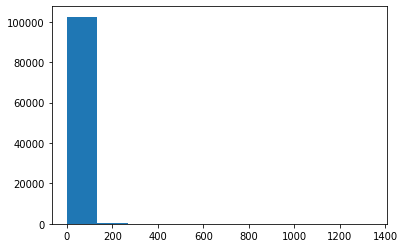

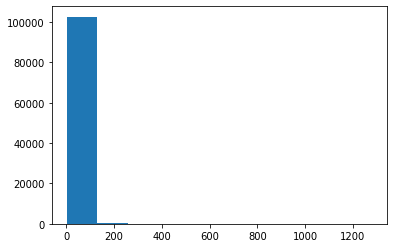

In [7]:
en_lens = [len(x.split()) for x in en_sentences]
fr_lens = [len(x.split()) for x in fr_sentences]

plt.figure()
plt.hist(en_lens)

plt.figure()
plt.hist(fr_lens)

en_mean = np.mean(en_lens)
en_std = np.std(en_lens)
fr_mean = np.mean(fr_lens)
fr_std = np.std(fr_lens)
en_max = np.max(en_lens)
fr_max = np.max(fr_lens)

print(f'English sentences : mean = {en_mean}, std = {en_std}, max = {en_max}')
print(f'French sentences : mean = {fr_mean}, std = {fr_std}, max = {fr_max}')

In [0]:
max_sequence_len = 30
en_vocab_size = 30000
fr_vocab_size = 30000

## Tokenization and Sequence Padding

In [0]:
def preprocess_en(en):
    encoded_en = en_tk.texts_to_sequences(en)
    padded_en = pad_sequences(encoded_en, maxlen=max_sequence_len, padding='post', truncating='post')
    return padded_en

def preprocess_fr(fr):
    encoded_fr = fr_tk.texts_to_sequences(fr)
    padded_fr = pad_sequences(encoded_fr, maxlen=max_sequence_len, padding='post', truncating='post')
    return padded_fr

def preprocess_text(en, fr):
    return preprocess_en(en.numpy().decode()), preprocess_fr(fr.numpy().decode())

## Preparing Training Dataset

In [10]:
train_ds = dataset['train']
train_en = []
train_fr = []
for example in tqdm(train_ds):
    train_fr.append(example[0].numpy().decode())
    train_en.append('startseq ' + example[1].numpy().decode() + ' endseq')
train_en = preprocess_en(train_en)
train_fr = preprocess_fr(train_fr)

batch_size = 80
train_dataset = tf.data.Dataset.from_tensor_slices((train_fr, train_en))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

100000it [00:23, 4274.20it/s]


## Defining Encoder, Decoder, and Attention Models using tf.keras Model Subclassing

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, hidden_size=1000, max_sequence_len=30, batch_size=batch_size, embedding_dim=620, vocab_size=30000):
        super(Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sequence_len = max_sequence_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.001)
        self.embedding_layer = Embedding(
            input_dim=self.vocab_size, output_dim=self.embedding_dim)
        self.GRU_1 = Bidirectional(GRU(units=hidden_size, return_sequences=True, return_state=True, kernel_initializer=self.initializer,
                                       bias_initializer='zeros'))

    def initial_hidden_state(self):
        return [tf.zeros(shape=(self.batch_size, self.hidden_size),) for i in range(2)]

    def call(self, x, initial_state, training=False):
        x = self.embedding_layer(x)
        x, hidden_state,_ = self.GRU_1(x, initial_state=initial_state)
        return x, hidden_state


class Attention(tf.keras.Model):
    def __init__(self, hidden_size=256):
        super(Attention, self).__init__()
        self.initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.001)
        self.fc1 = Dense(units=hidden_size, kernel_initializer=self.initializer,
                                       bias_initializer='zeros')
        self.fc2 = Dense(units=hidden_size, kernel_initializer=self.initializer,
                                       bias_initializer='zeros')
        self.fc3 = Dense(units=1, kernel_initializer=self.initializer,
                                       bias_initializer='zeros')

    def call(self, encoder_output, hidden_state, training=False):
        '''hidden_state : h(t-1)'''
        y_hidden_state = tf.expand_dims(hidden_state, axis=1)
        y_hidden_state = self.fc1(y_hidden_state)
        y_enc_out = self.fc2(encoder_output)

        y = tf.keras.backend.tanh(y_enc_out + y_hidden_state)
        attention_score = self.fc3(y)
        attention_weights = tf.keras.backend.softmax(attention_score, axis=1)

        context_vector = tf.multiply(encoder_output, attention_weights)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class Decoder(tf.keras.Model):
    def __init__(self, hidden_size=1000, max_sequence_len=30, batch_size=batch_size, embedding_dim=620, vocab_size=30000):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sequence_len = max_sequence_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.001)
        self.embedding_layer = Embedding(
            input_dim=self.vocab_size, output_dim=self.embedding_dim)
        self.GRU = GRU(units=hidden_size,
                       return_sequences=True, return_state=True)
        self.attention = Attention(hidden_size=self.hidden_size)
        self.fc = Dense(units=self.vocab_size, kernel_initializer=self.initializer,
                                       bias_initializer='zeros')

    def initial_hidden_state(self):
        return tf.zeros(shape=(self.batch_size, self.hidden_size))

    def call(self, x, encoder_output, hidden_state, training=False):
        x = self.embedding_layer(x)
        context_vector, attention_weights = self.attention(
            encoder_output, hidden_state, training=training)
        contect_vector = tf.expand_dims(context_vector, axis=1)
        x = tf.concat([x, contect_vector], axis=-1)
        x, curr_hidden_state = self.GRU(x)
        x = tf.reshape(x, shape=[self.batch_size, -1])
        x = self.fc(x)
        return x, curr_hidden_state, attention_weights

## Defining Training Loop, Loss Function and Optimizer

In [0]:
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adadelta(rho=0.95, epsilon=1e-06)
train_accuracy = tf.metrics.SparseCategoricalAccuracy()


def loss_function(y_true, y_pred):
    loss = loss_object(y_true, y_pred)
    mask = 1 - tf.cast(tf.equal(y_true, 0), 'float32')
    return tf.reduce_mean(loss * mask)
    
@tf.function()
def training_step(fr, en):    
    with tf.GradientTape() as Tape:
        encoder_init_state = encoder.initial_hidden_state()
        encoder_output, encoder_hidden_state = encoder(fr, encoder_init_state, training=True)
        decoder_hidden = encoder_hidden_state
        loss = 0
        acc = []
        current_word = tf.expand_dims(en[:, 0], axis=1)
        for word_idx in range(1, max_sequence_len):
            next_word = en[:, word_idx]
            logits, decoder_hidden, attention_weights = decoder(current_word, encoder_output, decoder_hidden, training=True)
            loss += loss_function(next_word, logits)
            acc.append(train_accuracy(next_word, logits))
            current_word = tf.expand_dims(next_word, axis=1)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = Tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss, tf.reduce_mean(acc)

In [0]:
encoder = Encoder()
decoder = Decoder()
checkpoint_dir = 'training'
checkpoint_prefix = 'training/ckpt'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

## Training the Model

In [14]:
epochs = 10
num_steps = NUM_SAMPLES // batch_size
for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')
    ep_loss = []
    ep_acc = []
    progbar = tf.keras.utils.Progbar(target=num_steps, stateful_metrics=[
                                     'curr_loss', 'curr_accuracy'], unit_name='batch')

    for step, example in enumerate(train_dataset):
        en = example[0]
        fr = example[1]
        loss, acc = training_step(en, fr)
        loss /= en.shape[1]
        for i in range(len(encoder.trainable_weights)):
          loss += 0.001 * tf.reduce_sum(tf.square(encoder.trainable_weights[i]))
        for i in range(len(decoder.trainable_weights)):
          loss += 0.001 * tf.reduce_sum(tf.square(decoder.trainable_weights[i]))
        ep_loss.append(loss)
        ep_acc.append(acc)
        progbar.update(
            step + 1, values=[('curr_loss', loss), ('curr_accuracy', acc)])

    if epoch % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    print(f'Metrics after epoch {epoch} : Loss => {np.mean(ep_loss):.3f} | Accuracy => {np.mean(ep_acc):.3f}')
checkpoint.save(file_prefix=checkpoint_prefix)

Epoch 1/10
1562/1562 [==============================] - 696s 446ms/batch - curr_loss: 3.7318 - curr_accuracy: 0.3657
Metrics after epoch 1 : Loss => 3.658 | Accuracy => 0.334
Epoch 2/10
1562/1562 [==============================] - 669s 428ms/batch - curr_loss: 2.7312 - curr_accuracy: 0.3885
Metrics after epoch 2 : Loss => 3.229 | Accuracy => 0.378
Epoch 3/10
1562/1562 [==============================] - 669s 428ms/batch - curr_loss: 3.1363 - curr_accuracy: 0.4060
Metrics after epoch 3 : Loss => 2.902 | Accuracy => 0.397
Epoch 4/10
1562/1562 [==============================] - 671s 430ms/batch - curr_loss: 2.1700 - curr_accuracy: 0.4230
Metrics after epoch 4 : Loss => 2.593 | Accuracy => 0.414
Epoch 5/10
1562/1562 [==============================] - 671s 429ms/batch - curr_loss: 2.3778 - curr_accuracy: 0.4392
Metrics after epoch 5 : Loss => 2.335 | Accuracy => 0.431
Epoch 6/10
1562/1562 [==============================] - 668s 428ms/batch - curr_loss: 2.5070 - curr_accuracy: 0.4538
Metrics 

'training/ckpt-6'

In [15]:
checkpoint.restore('training/ckpt-6')

## Inference Function

In [0]:
def translate_sentence(sentence):
    sentence = preprocess_en([sentence])
    enc_init = tf.zeros(shape=[1, 1024])
    enc_out, enc_hidden = encoder(sentence, enc_init)

    decoder.batch_size = 1
    fr_tk.index_word[0] = ''
    decoded = []
    att = []
    current_word = tf.expand_dims([fr_tk.word_index['startseq']], axis=0) 
    decoder_hidden = enc_hidden
    for word_idx in range(1, max_sequence_len):
        logits, decoder_hidden, attention_weights = decoder(current_word, enc_out, decoder_hidden)
        decoded_idx = np.argmax(logits)
        if fr_tk.index_word[decoded_idx] == 'endseq':
            break
        decoded.append(fr_tk.index_word[decoded_idx])
        att.append(attention_weights.numpy().squeeze())
        current_word = tf.expand_dims([decoded_idx], axis=0)
    return ' '.join(decoded), att

## Translating and Visualizing Attention Maps

EN :  There is a misunderstanding
FR :  what is a
------------------------------
EN :  what do you want ?
FR :  do you do you
------------------------------
EN :  are you mad ?
FR :  are you
------------------------------
EN :  state of the art
FR :  state of the art
------------------------------
EN :  the exam is going to be hard
FR :  the ideal center is to be ok
------------------------------
EN :  do you want to play with me ?
FR :  do you do you to get to
------------------------------
EN :  i love you
FR :  i pay
------------------------------
EN :  how are you doing ?
FR :  frantz you can be found
------------------------------
EN :  i should tell you that i am quite dangerous
FR :  i am sure me i am
------------------------------
EN :  Do you have any idea of how to use it ?
FR :  do you have any of your favorite tips to use it
------------------------------


<Figure size 288x216 with 0 Axes>

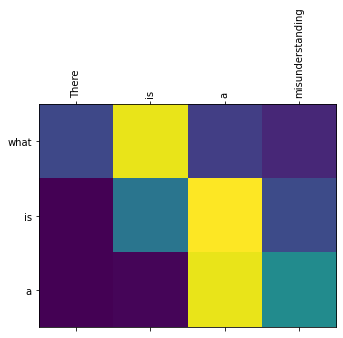

<Figure size 360x288 with 0 Axes>

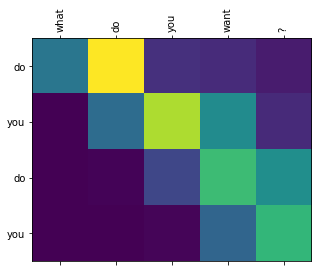

<Figure size 288x144 with 0 Axes>

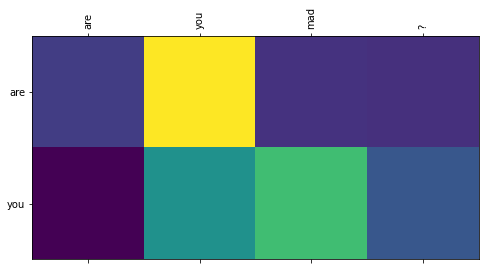

<Figure size 288x288 with 0 Axes>

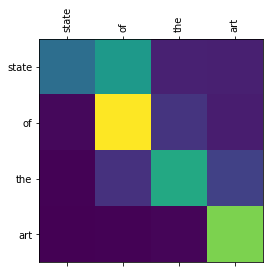

<Figure size 504x504 with 0 Axes>

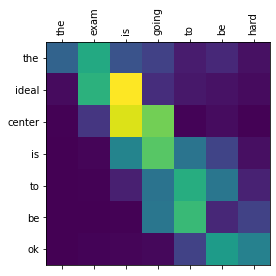

<Figure size 576x504 with 0 Axes>

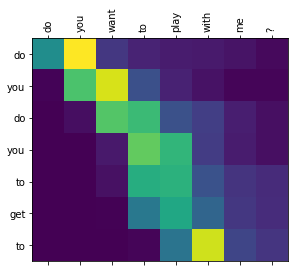

<Figure size 216x144 with 0 Axes>

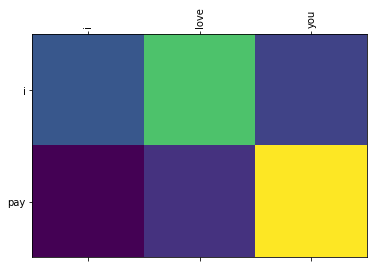

<Figure size 360x360 with 0 Axes>

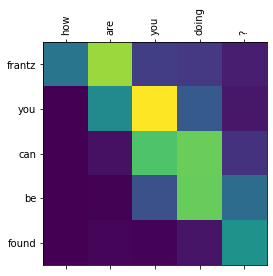

<Figure size 648x432 with 0 Axes>

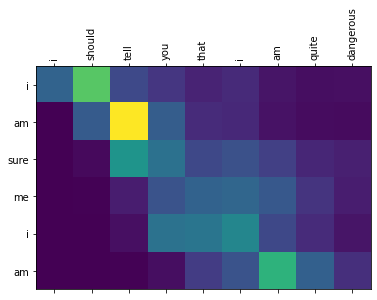

<Figure size 792x792 with 0 Axes>

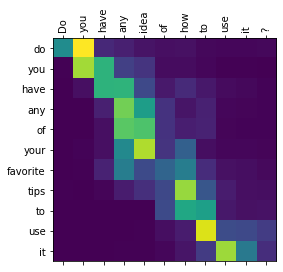

In [17]:
sentences = ["il y a un malentendu",
             'que veux tu',
             'es tu fou',
             "l'état de l'art",
             "l'examen est difficile", 
             'voulez vous jouer avec moi',
             "je t'aime",
             "comment allez vous",
             'je dois vous dire que je suis très dangereux',
             "as tu une idée de comment l'utiliser"]

for inp_sentence in sentences:
    inp_array = inp_sentence.split()
    inp_len = len(inp_sentence.split())
    trans_sentence, attention_weights = translate_sentence(inp_sentence)
    trans_array = trans_sentence.split()
    trans_len = len(trans_array)
    attention_weights = np.array([x for x in attention_weights])
    attention_weights = attention_weights[:trans_len,:inp_len]
    plt.figure(figsize=(inp_len, trans_len))
    plt.matshow(attention_weights)
    plt.xticks(ticks=range(inp_len), labels=inp_array, rotation=90)
    plt.yticks(ticks=range(trans_len), labels=trans_array)
    print('FR : ', inp_sentence)
    print('EN : ', trans_sentence)
    print('-'*30)